<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0877721, r0883565, r0874700, r0785071, r0874395</span>. (fill in your student numbers!)

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

### Obligatory Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/0docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import gc

### Optional Imports
Run the following if you want to additionally train the models instead of just loading them

In [2]:
! pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-uath3otc
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-uath3otc
  Resolved https://github.com/tensorflow/examples.git to commit c62c9ec403b441913c987cacdfaf4d7a0bf0e7f2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-c62c9ec403b441913c987cacdfaf4d7a0bf0e7f2_-py3-none-any.whl size=299285 sha256=abec0d7f359b4996ebf4bbd3b2a83eeb63310a0cd4d6429defb25f2a38252a46
  Stored in directory: /tmp/pip-ephem-wheel-cache-qt4amuiy/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Di

### Constants
Some constants defined to configure the rest of the notebook

In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 20
EPOCHS_CLASSIFICATION = 25

# If true, the classification model will be trained, else a fully pre-trained model will be loaded
CLASSIFICATION_TRAIN_FLAG = True

# If true, the segmentation model will be trained, else a fully pre-trained model will be loaded
SEGMENTATION_TRAIN_FLAG = False

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

### Load Training Data

In [4]:
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns

train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


### Visualize

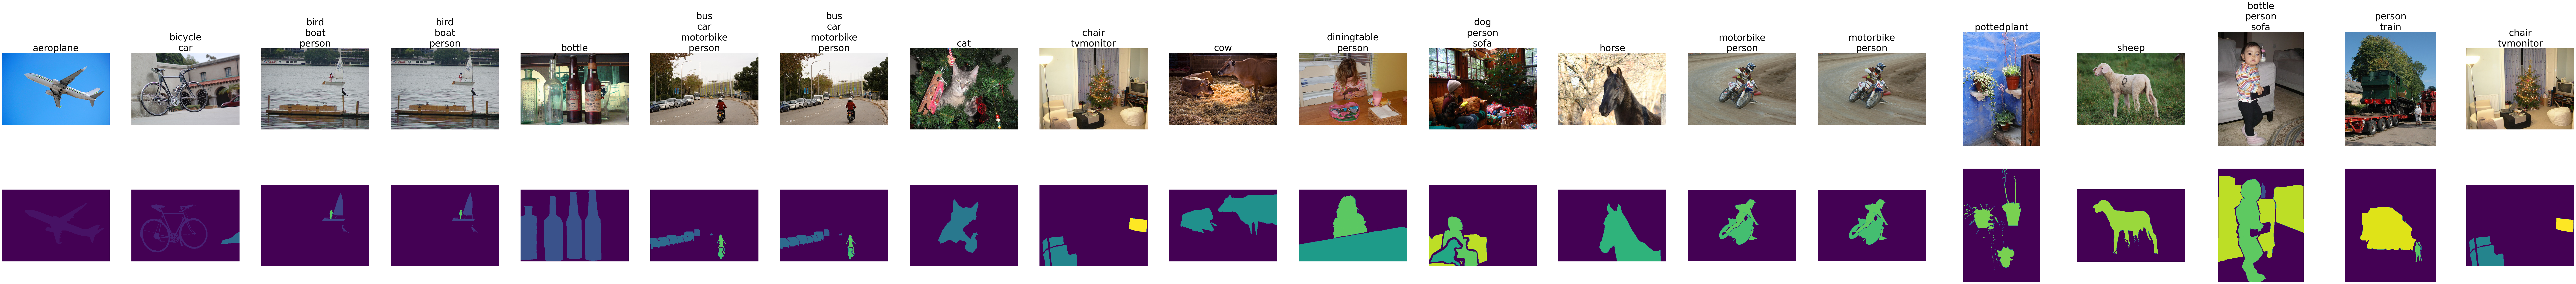

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  \
Id                                                                       
0            0        0     0     0       0    0    0    0      0    1   
1            0        0     0     0       1    0    0    0      0    0   
2            0        0     0     0       1    0    0    0      0    0   
3            0        0     0     0       0    0    0    1      0    0   
4            0        0     0     0       0    0    0    0      0    1   
..         ...      ...   ...   ...     ...  ...  ...  ...    ...  ...   
744          0        0     0     0       0    0    1    0      0    0   
745          0        1     0     0       0    0    1    0      0    0   
746          0        0     1     0       0    0    0    0      0    0   
747          0        0     0     0       0    0    0    0      0    0   
748          0        0     1     0       0    0    0    0      0    0   

     diningtable  dog  horse  motorbike  person  pottedplant  sheep  sofa  \
Id                                                                          
0              0    0      0          0       0            0      0     0   
1              0    0      0          0       0            0      0     0   
2              0    0      0          0       0            0      0     0   
3              0    0      0          0       0            0      0     0   
4              0    0      0          0       0            0      0     0   
..           ...  ...    ...        ...     ...          ...    ...   ...   
744            0    0      0          0       0            0      0     0   
745            0    0      0          0       1            0      0     0   
746            0    0      0          0       0            0      0     0   
747            0    0      0          0       0            0      0     0   
748            0    0      0          0       0            0      0     0   

     train  tvmonitor  
Id                     
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  
..     ...        ...  
744      0          0  
745      0          0  
746      0          0  
747      0          1  
748      0          0  

[749 rows x 20 columns]

In [5]:
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0,
                     vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")

plt.show()

train_df[labels]

### Loading Test Data

In [6]:
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

The test set contains 750 examples.


## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [7]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle


def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))

    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

## 1.4 Helper functions

In [8]:
def pad_img(img):
    return cv2.copyMakeBorder(img.copy(), 0, IMG_HEIGHT - img.shape[0], 0, IMG_WIDTH - img.shape[1],
                              cv2.BORDER_CONSTANT, value=[0, 0, 0])


def pad_images(imgs):
    return np.array([pad_img(img) for img in imgs])


def pad_seg(inp):
    res = []
    for row in inp:
        result = np.zeros([IMG_HEIGHT, IMG_WIDTH])
        result[:row.shape[0], :row.shape[1]] = row
        res.append(result)
    return np.array(res)


def get_max(_df, axis):
    _max = -1
    for row in _df:
        if row.shape[axis] > _max:
            _max = row.shape[axis]
    return _max


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

## 2.1 Build Model
We build the whole model by using a pre-trained base model, [VGG16](https://neurohive.io/en/popular-networks/vgg16/), with [ImageNet](https://www.image-net.org/) data. 
In addition, we add an input layer for the images and an output layer that emits 20 decimal numbers between 0 and 1 that express the possibility of the image belonging to each class (the sigmoid activation function is used). We freeze the pre-trained base model weights in an attempt to train the other layer weights and adjust them to our data. They will be unfrozen in the next step in order to fine-tune the pipeline. The summary of the pipeline is printed below.

In [9]:
input_layer = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
model = tf.keras.Model(input_layer, output_layer)

model.summary()

2022-05-24 21:52:45.847906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 21:52:45.952829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 21:52:45.953562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 21:52:45.954640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                10260     
Total params: 14,724,948
Trainable params: 10,260
Non-trainable params: 14,714,688
_________________________________________________________________


## 2.2 Visualize Full Model
Display an image that visualizes the whole model pipeline.

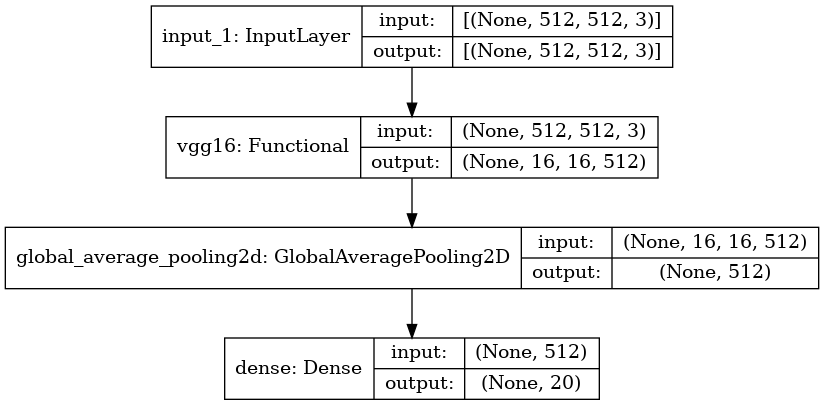

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 2.3 Train Model
Compile and train the whole model. Beware that we have to pad the images to a max size (512x512), as we want all of them to be of the same size. 

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

if CLASSIFICATION_TRAIN_FLAG:
    model.fit(pad_images(train_df['img']), train_df[labels], epochs=EPOCHS_CLASSIFICATION)

2022-05-24 21:52:54.178356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-05-24 21:52:55.587488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


24/24 [==============================] - 27s 493ms/step - loss: 0.6521 - binary_accuracy: 0.8258
Epoch 2/25
24/24 [==============================] - 6s 265ms/step - loss: 0.3445 - binary_accuracy: 0.9194
Epoch 3/25
24/24 [==============================] - 6s 265ms/step - loss: 0.2542 - binary_accuracy: 0.9270
Epoch 4/25
24/24 [==============================] - 6s 265ms/step - loss: 0.2087 - binary_accuracy: 0.9339
Epoch 5/25
24/24 [==============================] - 6s 266ms/step - loss: 0.1770 - binary_accuracy: 0.9416
Epoch 6/25
24/24 [==============================] - 6s 265ms/step - loss: 0.1540 - binary_accuracy: 0.9482
Epoch 7/25
24/24 [==============================] - 6s 265ms/step - loss: 0.1364 - binary_accuracy: 0.9539
Epoch 8/25
24/24 [==============================] - 6s 265ms/step - loss: 0.1238 - binary_accuracy: 0.9583
Epoch 9/25
24/24 [==============================] - 6s 264ms/step - loss: 0.1127 - binary_accuracy: 0.9620
Epoch 10/25
24/24 [============================

## 2.3.1 Fine-Tuning
After the training of our edge layers, we fine-tune the whole pipeline. Firstly, we unfreeze the pre-trained base model, and then we recompile the whole pipeline with a very low learning rate to adjust it to our data. At the end, we train again for few epochs (3).

In [12]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
if CLASSIFICATION_TRAIN_FLAG:
    model.fit(pad_images(train_df['img']), train_df[labels], epochs=2)

Epoch 1/2
24/24 [==============================] - 31s 1s/step - loss: 0.0426 - binary_accuracy: 0.9848
Epoch 2/2
24/24 [==============================] - 24s 1s/step - loss: 0.0234 - binary_accuracy: 0.9931


## 2.3.2 (Optional) Load Classification Model
Use this cell if you want to skip the training time. A pre-trained model is loaded.

In [13]:
if not CLASSIFICATION_TRAIN_FLAG:
    model=tf.keras.models.load_model('/kaggle/input/pretrainedmodels/classification_model_ep30_tune3.h5')

## 2.3.2 (Optional) Save Classification Model
Use this cell if you want to save the trained model

In [14]:
if CLASSIFICATION_TRAIN_FLAG:
    model.save('classification_model.h5')

## 2.4 Predict
We pad the test images to 512x512 and get the results from the trained model. The output of the model is a 20-vector with decimals values between 0 and 1. Then, we round them to 0 or 1 depending on whether they are greater than 0.5 or not. These are the final classification labels to be submitted.

In [15]:
results = model.predict(pad_images(test_df['img']))
results = np.where(results > 0.5, 1, 0)
test_df.loc[:, labels] = results

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

## 3.1 U-Net Image Segmentation Pipeline
We used a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) model to classify each pixel of our input images. Essentialy, we followed [this](https://www.tensorflow.org/tutorials/images/segmentation) guide with modifications that resulted in the following architecture:

### 3.1.2 Downsampling
The first part of the U-Net model consists of downsampling, by using layers from a pre-trained base model, [MobileNetV2](https://paperswithcode.com/method/mobilenetv2), with [ImageNet](https://www.image-net.org/) data. Specifically, we use the activations of the below specified layers, and freeze the weights of the full down stack. 

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 512x512
    'block_3_expand_relu',   # 256x256
    'block_6_expand_relu',   # 128x128
    'block_13_expand_relu',  # 64x64
    'block_16_project',      # 32x32
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


### 3.1.3 Upsampling
The second part of the pipeline consists of upsampling again to generate an array having the same size as the original image. We use [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix) to create the layers of this part.

In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 32 -> 64
    pix2pix.upsample(256, 3),  # 64 -> 128
    pix2pix.upsample(128, 3),  # 128 -> 256
    pix2pix.upsample(64, 3),   # 256 -> 512
]

### 3.1.3 Connect Downsampling and Upsampling
Finally, we connect the downsampling and upsampling parts to construct the full pipeline. The input layer has the same shape as the padded images (512x512) and the output layer results in a (512x512x21) tensor for each image, representing each pixel's classifcation. 

In [18]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #256x256 -> 512x512

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 3.2 Compile Full Model
Compile and visualize the full model.

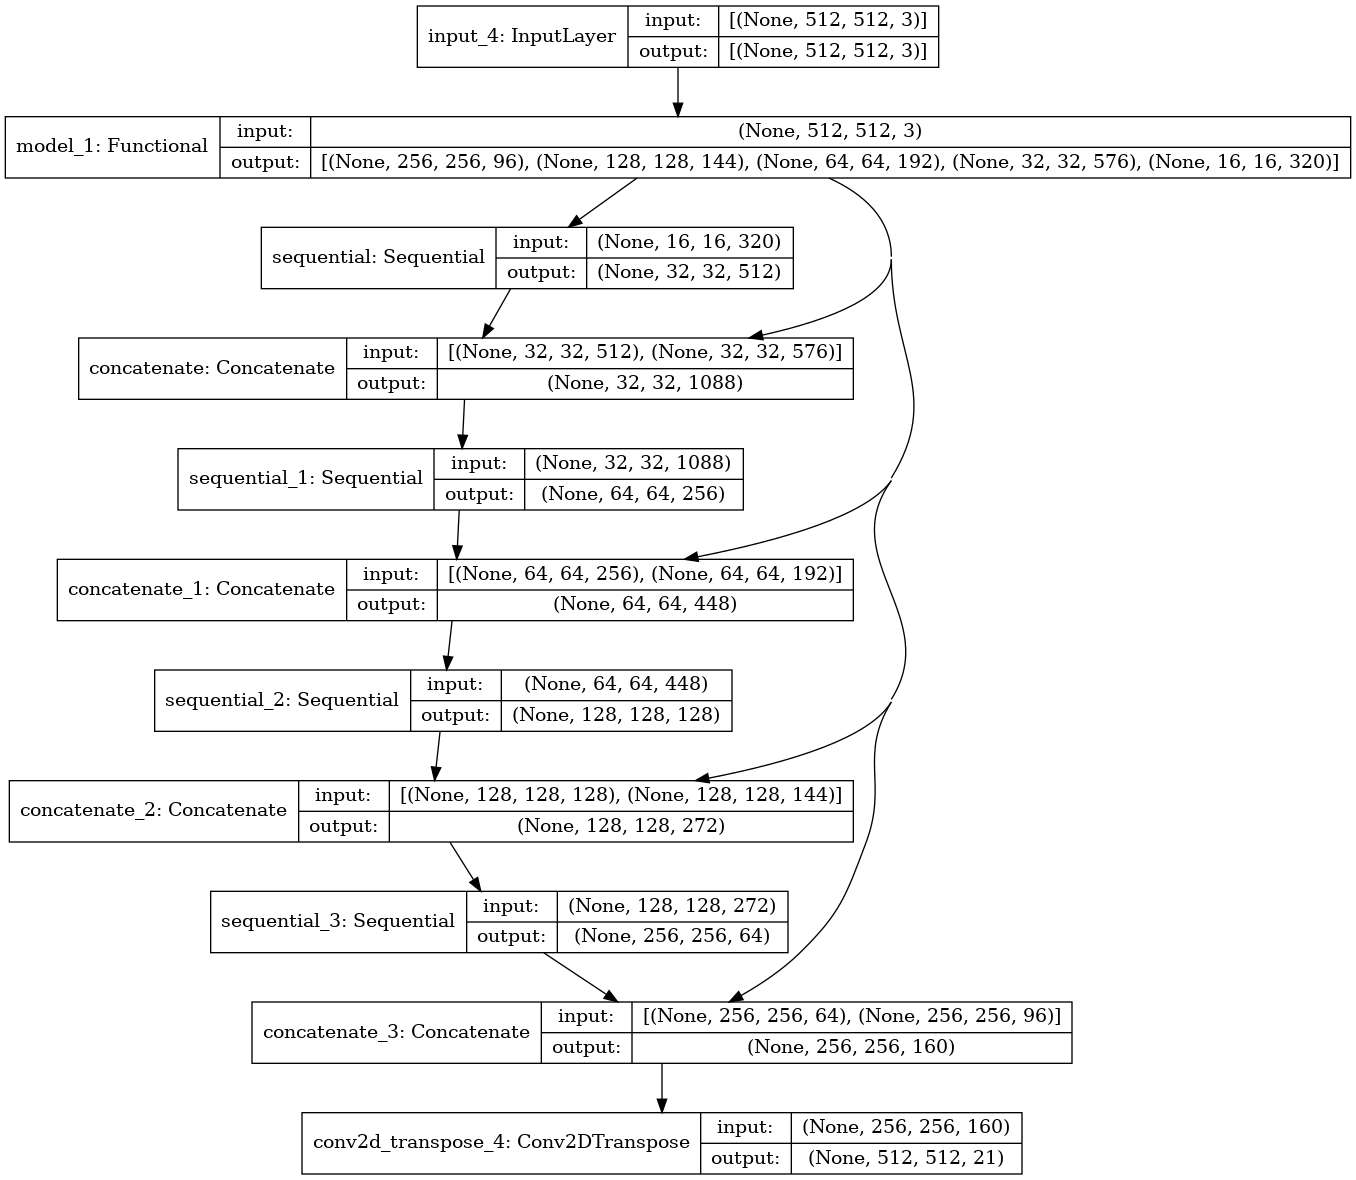

In [19]:
model = unet_model(output_channels=NUM_CLASSES + 1)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

## 3.3.1 Train Full Model (Not Recommended)
The full model is trained here. However, we don't recommend running this cell, but instead load the pretrained model. The reason is that this training is memory intensive and may result in crashes.

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(normalize(pad_images(train_df['img']), pad_seg(train_df['seg'])))
train_dataset = train_dataset.batch(4).shuffle(100)
# .shuffle(BUFFER_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)

if SEGMENTATION_TRAIN_FLAG:
    del train_df
    gc.collect()
    model.fit(train_dataset, epochs=40)

2022-05-24 21:58:27.968179: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1570766848 exceeds 10% of free system memory.
2022-05-24 21:58:29.549918: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2356150272 exceeds 10% of free system memory.
2022-05-24 21:58:31.514073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1570766848 exceeds 10% of free system memory.


## 3.3.2 Load Model
Load a pre-trained model to skip the training time.

In [21]:
if not SEGMENTATION_TRAIN_FLAG:
    model = tf.keras.models.load_model('/kaggle/input/pretrainedmodels/segmentation_model.h5')

## 3.3.3 Save Model
Save the model.

In [22]:
if SEGMENTATION_TRAIN_FLAG:
    model.save('segmentation_model.h5')

## 3.4 Prediction
Predict the test data segmentation for submission

In [23]:
normalized = tf.cast(pad_images(test_df['img']), tf.float32) / 255.0
test_dataset = tf.data.Dataset.from_tensor_slices(normalized)
res=[]
for i, row in enumerate(test_dataset):
    pred_mask = create_mask(model.predict(tf.expand_dims(row, axis=0)))
    res.append(pred_mask[:test_df['seg'][i].shape[0], :test_df['seg'][i].shape[1], 0].numpy().astype('int8'))
    
test_df['seg'] = res

2022-05-24 21:58:42.455273: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2359296000 exceeds 10% of free system memory.
2022-05-24 21:58:44.393765: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2359296000 exceeds 10% of free system memory.


## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [24]:
generate_submission(test_df)

Predicted
Id                                                                   
0_classification                                             9 1 11 1
0_segmentation      352640 1 353140 2 353640 2 353645 1 926352 1 9...
1_classification                                             9 1 18 1
1_segmentation      1761872 1 1762380 1 1762871 4 1762877 4 176293...
2_classification                                        9 1 11 1 18 1
...                                                               ...
747_segmentation    396124 1 396621 5 397122 3 397621 4 398122 3 3...
748_classification                                               15 1
748_segmentation    169383 1 170383 2 171377 1 171381 1 171383 2 1...
749_classification                                          11 1 16 1
749_segmentation    812702 3 813037 3 813372 3 813707 3 814042 3 8...

[1500 rows x 1 columns]

# 4. Adversarial Attack
Next, we want to create a CNN that generates adversarial attacks for our classifier CNN. These attacks are a noisy image that, when combined with a normal image in the dataset, tricks our classifier CNN into misclassifying this perturbed image. At the same, the perturbed image looks like the original dataset image to the human eye.

Looking at GAN and Encoder-Decoder architectures, we chose to implement a similar architecture to GAN. The main idea is to create a generator (f) in two parts - models, and reuse our classifier CNN as the discriminator (h). The first model of the generator takes the training dataset images (X) as input, and classifies (ŷ) them in the opposite way than our classifier - i.e. if there's a horse in the image, we train it to label is as not present, and vice versa. The second model of the generator will take as input the output of the first model - i.e. the labels, alongside a random noise vector. The output of this model is the noise (𝛿) that will be added to the original image (X+𝛿) and fed to our discriminator.

The loss function for the first model (R(𝛿)) in the generator is a regularization element (a norm), so that the perturbed image (X+𝛿) looks like the original one to the human eye.
The loss function for the second model (L(y,ŷ)) in the generator is the binary cross entropy of two labels - the true labels from the dataset and the discriminator prediction of the perturbed image. This loss function is meant to teach the generator how to trick the discriminator.

Unfortunately, due to time constraints, we were not able to fully test our implementation of the adversarial attack. However, we believe this architecture is sound and should be able to trick our Classifier CNN while still making a perturbed image similar to the original one in the dataset.

 ![Adversarial Model Diagram](https://i.imgur.com/c7bI2XH.png)

In [25]:
# import tensorflow as tf
# from tensorflow.keras.layers import (Dense, 
#                                      BatchNormalization, 
#                                      LeakyReLU, 
#                                      Reshape, 
#                                      Conv2DTranspose,
#                                      Conv2D,
#                                      Dropout,
#                                      Flatten)
# import matplotlib.pyplot as plt

# def make_decoder_model():
#     model = tf.keras.Sequential()
#     model.add(Dense(125*125*96, use_bias=False, input_shape=(20,)))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())

#     model.add(Reshape((125, 125, 96)))
#     assert model.output_shape == (None, 125, 125, 96) # Note: None is the batch size

#     model.add(Conv2DTranspose(48, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, 125, 125, 48)
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())

#     model.add(Conv2DTranspose(12, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 250, 250, 12)
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())

#     model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, 500, 500, 3)

#     return model

In [26]:
# classifier = keras.models.load_model('/kaggle/input/models/classification_model_ep30_tune3.h5')
# encoder = classifier
# # Create a random noise and generate a sample
# noise = tf.random.normal([1, 20])
# decoder = make_decoder_model()
# generated_image = decoder(noise, training=False)
# # Visualize the generated sample
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# print(generated_image[0, 100,100,0])

In [27]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def encoder_loss(real_lable, fake_lable):
#     loss = cross_entropy(real_lable, fake_lable)
#     return 1 - loss

# def decoder_loss(fake_output, real_input):
#     return cross_entropy(real_input, fake_output)

# encoder_optimizer = tf.keras.optimizers.Adam(1e-4)
# decoder_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
# # tf.function annotation causes the function 
# # to be "compiled" as part of the training
# @tf.function
# def train_step(images, lables):
    
    
#     # GradientTape method records operations for automatic differentiation.
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
#         mid_label = encoder(images, training=True)
#         generated_added_noise = decoder(mid_label, training=True)
    
#         class_label = classifier(images + generated_added_noise, training=False)

#         dec_loss = decoder_loss(images + generated_added_noise, images)
#         enc_loss = encoder_loss(lables, class_label)

    
#     gradients_of_generator = gen_tape.gradient(gen_loss, 
#                                                generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, 
#                                                 discriminator.trainable_variables)
    
#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [29]:
# def generate_and_save_images(model, epoch, test_input):
#   # Notice `training` is set to False.
#   # This is so all layers run in inference mode (batchnorm).
#   # 1 - Generate images
#     predictions = model(test_input, training=False)
#   # 2 - Plot the generated images
#     fig = plt.figure(figsize=(4,4))
#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#         plt.axis('off')
#   # 3 - Save the generated images
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()

In [30]:
# import time
# from IPython import display # A command shell for interactive computing in Python.

# def train(dataset, epochs):
#   # A. For each epoch, do the following:
#   for epoch in range(epochs):
#     start = time.time()
#     # 1 - For each batch of the epoch, 
#     for image_batch in dataset:
#       # 1.a - run the custom "train_step" function
#       # we just declared above
#         train_step(image_batch, lables)

#     # 2 - Produce images for the GIF as we go
#     display.clear_output(wait=True)
#     generate_and_save_images(generator,
#                              epoch + 1,
#                              seed)

#     # 3 - Save the model every 5 epochs as 
#     # a checkpoint, which we will use later
#     # 4 - Print out the completed epoch no. and the time spent
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#   # B. Generate a final image after the training is completed
#     display.clear_output(wait=True)
# generate_and_save_images(generator,
#                            epochs,
#                            seed)
# train(train_dataset, 1)

# 5. Discussion

Firstly, we sedimented the importance of data preprocessing, since it is fundamental for us to be able to train a model that yields any significant results. We did that by resizing the images to a more manageable size, making the images uniform with padding and normalizing the values.

Secondly, we tried both (multiple) pre-trained models and defining our own models from scratch for classification and segmentation. However, we found pre-trained models to perform better, which is expected, since the weights are meaningful. 

Furthermore, we learned not to underestimate how memory-intensive training can be, and we also learned some techniques for mitigating that problem. The one we used the most was to delete unused variables and explicitly use the garbage collector to free up space. 

We learned that adverserial attacks can be very dangerous due to real-life applications, such as tricking the CNN of a self-driving car. This can be mitigated by using the adversarial network during training. By using perturbed images in training, the classifier becomes more robust to perturbations, and thus classify images in a more human-like way.

We believe our classification and segmentation performed fairly well (approximately 65% accuracy). If we had more time, we would definitely focus on optimizing memory usage, trying to get more data for the networks to train on more examples, and do more in-depth research in the current literature.

One clear limitation of our models is that the accuracy is not sufficient for most real-world scenarios.
